In [1]:
from IPython import display
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import omegaconf
import pickle

import os
os.environ['PATH'] += os.pathsep + os.pathsep.join(["C:\\Users\\kehua\\.mujoco\\mujoco200\\bin;%PATH%"])

import mbrl.env.cartpole_continuous as cartpole_env
import mbrl.env.cartpole_continuous_down as cartpole_env_down
import mbrl.env.cartpole_continuous_travel as cartpole_env_travel
# import mbrl.env.pets_halfcheetah as half_cheetah
# import mbrl.env.pets_pusher as pusher
# import mbrl.env.pets_reacher as reacher
# import mbrl.env.humanoid_standup as humanoid_standup
import mbrl.env.obstacles as obstacles

import mbrl.env.reward_fns as reward_fns
import mbrl.env.termination_fns as termination_fns
import mbrl.models as models
import mbrl.planning as planning
import mbrl.util.common as common_util
import mbrl.util as util
from mbrl.types import TransitionBatch

from tqdm import tqdm

import importlib
importlib.reload(models)
importlib.reload(cartpole_env_down)
importlib.reload(planning)
importlib.reload(common_util)

%load_ext autoreload
%autoreload 2

mpl.rcParams.update({"font.size": 16})

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [2]:
seed = 0
env = cartpole_env_down.CartPoleEnvDown()
env.seed(seed)
env2 = cartpole_env_down.CartPoleEnvDown()
env2.seed(seed)

rng = np.random.default_rng(seed=0)
generator = torch.Generator(device=device)
generator.manual_seed(seed)
obs_shape = env.observation_space.shape
act_shape = env.action_space.shape

# This functions allows the model to evaluate the true rewards given an observation 
reward_fn = reward_fns.cartpole_down
# This function allows the model to know if an observation should make the episode end
term_fn = termination_fns.cartpole_down

In [3]:
trial_length = 60
num_trials = 8
ensemble_size = 5
n_delay = 1

# Everything with "???" indicates an option with a missing value.
# Our utility functions will fill in these details using the 
# environment information
cfg_dict = {
    # dynamics model configuration
    "dynamics_model": {
        "model": {
            "_target_": "mbrl.models.GaussianMLP",
            "device": device,
            "num_layers": 3,
            "ensemble_size": ensemble_size,
            "hid_size": 200,
            "use_silu": True,
            "in_size": "???",
            "out_size": "???",
            "deterministic": False,
            "propagation_method": "fixed_model"
        }
    },
    # options for training the dynamics model
    "algorithm": {
        "learned_rewards": False,
        "target_is_delta": True,
        "normalize": True,
    },
    # these are experiment specific options
    "overrides": {
        "trial_length": trial_length,
        "num_steps": num_trials * trial_length,
        "model_batch_size": 32,
        "validation_ratio": 0.05
    }
}
cfg = omegaconf.OmegaConf.create(cfg_dict)

agent_cfg = omegaconf.OmegaConf.create({
    # this class evaluates many trajectories and picks the best one
    "_target_": "mbrl.planning.TrajectoryOptimizerAgent",
    "planning_horizon": 45,
    "replan_freq": 1,
    "verbose": False,
    "action_lb": "???",
    "action_ub": "???",
    "resample": False,
    # this is the optimizer to generate and choose a trajectory
    "optimizer_cfg": {
        "_target_": "mbrl.planning.GradientOptimizer",
        "num_iterations": 5,
        "elite_ratio": 0.1,
        "population_size": 10,
        "alpha": 0.1,
        "device": device,
        "lower_bound": "???",
        "upper_bound": "???",
        "return_mean_elites": True,
        "num_top": 1,
        "resample_amount": 10
    }
})

In [4]:
train_losses = []
val_scores = []

def train_callback(_model, _total_calls, _epoch, tr_loss, val_score, _best_val):
    train_losses.append(tr_loss)
    val_scores.append(val_score.mean().item())   # this returns val score per ensemble model

# RUN

In [5]:
dreward_total = {}
for trial in range(num_trials):
    dreward_total[trial] = []
    
values_total = {}
for trial in range(num_trials):
    values_total[trial] = []
    
values_prior = {}
for trial in range(num_trials):
    values_prior[trial] = []
    
values_total2 = {}
for trial in range(num_trials):
    values_total2[trial] = []

In [6]:
rew_all = []
rew_all2 = []

experiment: 0, trial: 0. Step 0
experiment: 0, trial: 0. Step 1
experiment: 0, trial: 0. Step 2
experiment: 0, trial: 0. Step 3
experiment: 0, trial: 0. Step 4


KeyboardInterrupt: 

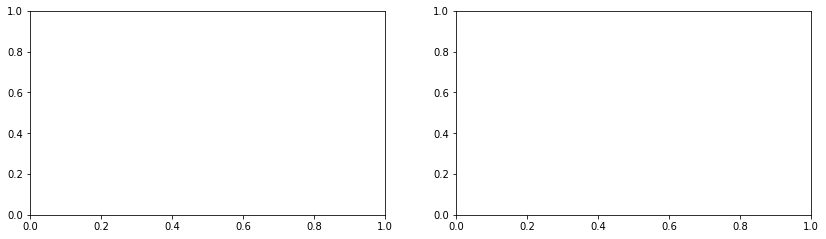

In [9]:
num_experiments = 20
for experiment_number in range(num_experiments):
    # Create a 1-D dynamics model for this environme|nt
    dynamics_model = common_util.create_one_dim_tr_model(cfg, obs_shape, act_shape, n_delay=n_delay)

    # Create a gym-like environment to encapsulate the model
    model_env = models.ModelEnv(env, dynamics_model, term_fn, reward_fn, generator=generator, n_delay=n_delay)
    replay_buffer = common_util.create_replay_buffer(cfg, obs_shape, (act_shape[0]*(n_delay + 1), ), rng=rng, n_delay=n_delay)

    common_util.rollout_agent_trajectories(
        env,
        model_env,
        trial_length*50, # initial exploration steps
        planning.RandomAgent(env),
        {}, # keyword arguments to pass to agent.act()
        replay_buffer=replay_buffer,
        trial_length=trial_length
    )

    num_particles = 20
    agent = planning.create_trajectory_optim_agent_for_model(
        model_env,
        agent_cfg,
        num_particles=num_particles
    )
    agent2 = planning.create_trajectory_optim_agent_for_model(
        model_env,
        agent_cfg,
        num_particles=num_particles
    )

    %matplotlib inline
    import pickle
    importlib.reload(models)
    importlib.reload(cartpole_env_down)
    importlib.reload(planning)
    importlib.reload(common_util)

    # Create a trainer for the model
    model_trainer = models.ModelTrainer(dynamics_model, optim_lr=1e-3, weight_decay=5e-5)

    # trajectory_renderer = TrajectoryRenderer(env.x_threshold, env.length, int(1 + np.ceil(50/5)))

    # Create visualization objects
    fig, axs = plt.subplots(1, 2, figsize=(14, 3.75), gridspec_kw={"width_ratios": [1, 1]})
    ax_text = axs[0].text(300, 50, "")

    trajectories_actions_all = []
    trajectories_states_all = []
    trajectories_actions_extra_all = []
    obs_all = []
    dreward_all = []
    all_optimized_all = []
    all_values_all = []
    optim_traj_values_all = []
    top_traj_values_all = []
    extra_traj_optim_all = []
    all_values_optim_all = []
    extra_traj_all_optimized_all = []
    extra_traj_values_all = []
    errors_all = []
    true_traj_all = []
    values_before_all = []
    # Main PETS loop
    all_rewards = [0]
    all_rewards2 = [0]
    for trial in range(num_trials):
        obs = env.reset()
        env2.reset()
        agent.reset()
        agent2.reset()
        model_env.reset_prev_actions()

        done = False
        total_reward = 0.0
        steps_trial = 0
        trajectories_actions_trial = []
        trajectories_actions_extra_trial = []
        trajectories_states_trial = []
        obs_trial = []
        dreward_trial = []
        all_optimized_trial = []
        all_values_trial = []
        optim_traj_values_trial = []
        values_before_trial = []
        top_traj_values_trial = []
        extra_traj_optim_trial = []
        all_values_optim_trial = []
        extra_traj_all_optimized_trial = []
        extra_traj_values_trial = []
        error_trial = []
        true_traj_trial = []
        while not done:
            env.render()
            print(f'experiment: {experiment_number}, trial: {trial}. Step {steps_trial}')
            # --------------- Model Training -----------------
            if steps_trial == 0:
                dynamics_model.update_normalizer(replay_buffer.get_all())  # update normalizer stats

                dataset_train, dataset_val = replay_buffer.get_iterators(
                    batch_size=cfg.overrides.model_batch_size,
                    val_ratio=cfg.overrides.validation_ratio,
                    train_ensemble=True,
                    ensemble_size=ensemble_size,
                    shuffle_each_epoch=True,
                    bootstrap_permutes=False,  # build bootstrap dataset using sampling with replacement
                )

                model_trainer.train(
                    dataset_train, dataset_val=dataset_val, num_epochs=50, patience=50, callback=train_callback)

            true_traj_trial.append(obs)

            # --- Doing env step using the agent and adding to model dataset ---
            next_obs, reward, done, _ = common_util.step_env_and_add_to_buffer_optim(env, model_env, obs, agent, {}, replay_buffer, use_opt=True)

            obs = next_obs
            total_reward += reward
            steps_trial += 1

            if steps_trial == trial_length:
                break

        print('total reward', total_reward)

    rew_all.append(all_rewards)